# Tutorial: Chromatin Polymer Modeling

This notebook provides a comprehensive guide to using the chromatin polymer modeling codebase. The code simulates chromatin folding using loop extrusion by SMC complexes.

## Overview

The modeling workflow consists of two main stages:
1. **1D Simulation**: Simulates loop extrusion on a 1D lattice where SMC complexes bind, extrude loops, and unbind
2. **3D Simulation**: Uses molecular dynamics to fold the polymer in 3D space based on the loop constraints from the 1D simulation

**Note**: In the main article ("Effects of Extruder Dynamics and Noise on Simulated Chromatin Contact Probability Curves"), we modeled 40 Mbp chromosomes. However, in this tutorial we use a smaller 200 kbp example for simplicity and computational speed.

## Key Components

- `bead.py`: Defines the Bead class representing polymer segments
- `smc.py`: Defines SMC complex classes (Extruder, Cohesin, Border) for loop extrusion
- `ensemble_director.py`: Manages the ensemble of objects (beads, SMC complexes) during simulation
- `spatial_functions.py`: Functions for 3D polymer simulation setup and bond management
- `file_handlers.py`: Functions for reading/writing simulation data
- `draw_and_plot.py`: Functions for visualization and contact map generation
- `loop_statistics.py`: Functions for analyzing loop distributions


## 1. Setting Up a Basic Simulation

Let's start by creating a simple polymer chain with static extruders.


In [1]:
import numpy as np
import json

# Import necessary classes
from bead import Bead
from smc import Extruder, Border
from ensemble_director import ensemble_director

# Define polymer chain parameters (for this example)
# Note: In the main article, we modeled 40 Mbp. Here we use 200 kbp for demonstration.
bead_sizes = [200] * 1000  # 1000 beads, each 200 bp
chain_length_bp = sum(bead_sizes)  # Total length: 200,000 bp (200 kbp)

print(f"Chain length: {chain_length_bp:,} bp (200 kbp)")
print(f"Number of beads: {len(bead_sizes)}")
print(f"Note: Main article used 40 Mbp. This is a smaller example for speed.")


Chain length: 200,000 bp (200 kbp)
Number of beads: 1000
Note: Main article used 40 Mbp. This is a smaller example for speed.


### 1.1 Define Bead Parameters

The `Bead` class represents a segment of the chromatin fiber. Each bead typically represents ~200 bp (one nucleosome).


In [2]:
# Create bead parameters dictionary
bead_pars = {
    'name': 'chain',
    'objects_number': len(bead_sizes),
    'objects_sizes': bead_sizes,
    'two_chain': False,  # Single chain (not sister chromatids)
    'objects_general_type': 'Bead',
}

print("Bead parameters:", json.dumps(bead_pars, indent=2))


Bead parameters: {
  "name": "chain",
  "objects_number": 1000,
  "objects_sizes": [
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    200,
    20

### 1.2 Define SMC Complex Parameters

SMC complexes (condensins/cohesins) are the loop-extruding factors. We can use either:
- **Static extruders**: Fixed positions, no dynamics
- **Dynamic extruders**: Bind/unbind stochastically with defined lifetime


In [3]:
# Example: Static extruders with exponential loop size distribution

avg_loop_size_bp = 100000  # 100 kbp average loop size
loop_spacing_bp = 400  # 400 bp spacing between loops

# Generate static extruder positions
static_extruder_positions = []
first_leg_pos = 1
second_leg_pos = int(first_leg_pos + np.random.exponential(scale=avg_loop_size_bp) // 200)

while second_leg_pos < len(bead_sizes) - 2:
    static_extruder_positions.append([first_leg_pos, second_leg_pos])
    loop_length = np.random.exponential(scale=avg_loop_size_bp)
    first_leg_pos = int(second_leg_pos + loop_spacing_bp // 200)
    second_leg_pos = int(first_leg_pos + loop_length // 200)

print(f"Number of static extruders: {len(static_extruder_positions)}")
print(f"First few positions: {static_extruder_positions[:3]}")


Number of static extruders: 4
First few positions: [[1, 27], [29, 242], [244, 439]]


In [4]:
# Define extruder parameters
attrs_condensin = {
    "Active": False,
    "Condensin+": 0.0,
    "Condensin-": 0.0,
}

args_condensin = {
    "type": "Condensin",
    "beads_number": len(bead_sizes),
    "n_steps": 5,  # Steps per movement
    "force": 0.2,  # Extrusion force
    "change_dir_prob": 0.5,  # Probability to switch active leg
    "diff_prob": 0.0,  # Diffusion probability
    "avgloopsize_bp": avg_loop_size_bp,
    "lifetime": 1e100,  # Infinite lifetime for static extruders
    "velocity": 0,  # No movement for static
    "pushing": False,  # Don't push other complexes
}

condensin_pars = {
    'name': 'condensin1',
    'objects_number': len(static_extruder_positions),
    'objects_general_type': 'Extruder',
    'args_smc': args_condensin,
    'attrs_smc': attrs_condensin,
    'positions': static_extruder_positions,
}


### 1.3 Create Ensemble Director

The `ensemble_director` class manages all objects in the simulation (beads, SMC complexes, etc.).


In [5]:
# Combine all parameters
par_dict = {
    'chain': bead_pars,
    'condensin1': condensin_pars,
}

# Create output directory
import os
path_to_files = './tutorial_simulation/'
if not os.path.exists(path_to_files):
    os.makedirs(path_to_files)

# Initialize ensemble director
ensemble = ensemble_director(
    params_dict=par_dict,
    path_to_files=path_to_files,
    dinamic_model=False  # Static model (no binding/unbinding)
)

print("Ensemble director created successfully!")
print(ensemble.get_object_info())


{'condensin1': {'object_general_type': 'Extruder', 'onbead_number': 0, 'total_number': 4}}
Setup complete!
Ensemble director created successfully!
{'chain': {'object_general_type': 'Bead', 'onbead_number': 1000, 'total_number': 1000}, 'condensin1': {'object_general_type': 'Extruder', 'onbead_number': 0, 'total_number': 4}}


## 2. Key Functions Reference

### 2.1 Bead Class

The `Bead` class represents individual segments of the chromatin fiber.


In [6]:
# Create a bead
bead = Bead(indx=0, border_state=False, chain=0, size=200)

print(f"Bead index: {bead.indx}")
print(f"Bead size: {bead.size} bp")
print(f"Border state: {bead.border_state}")
print(f"Residents: {bead.residents}")

# Beads can have "residents" (objects like SMC complexes) associated with them
# This is managed automatically by the SMC classes


Bead index: 0
Bead size: 200 bp
Border state: False
Residents: []


### 2.2 Spatial Functions

Functions for setting up 3D polymer simulations and managing bonds.


In [7]:
from spatial_functions import bond_calculator, make_start_conf

# Calculate bond distances between beads
bond_distances = bond_calculator(
    bead_sizes=bead_sizes,
    beads_in_one=1,
    base_bead_nm=10.0,
    two_chains=False
)

print(f"Bond distances calculated: {len(bond_distances)} bonds")
print(f"Mean bond distance: {np.mean(bond_distances):.2f} units")

# Create starting conformation (random walk)
starting_conf = make_start_conf(
    N=len(bead_sizes),
    BondDist=bond_distances,
    starting_conformation='random_walk',
    bead_dencity=0.1
)

print(f"Starting conformation shape: {starting_conf.shape}")
print(f"Starting positions range: X[{starting_conf[:, 0].min():.1f}, {starting_conf[:, 0].max():.1f}]")


Bond distances calculated: 999 bonds
Mean bond distance: 10.00 units
Starting conformation shape: (1000, 3)
Starting positions range: X[-86.3, 130.5]


### 2.3 Loop Statistics

Functions for analyzing loop distributions and identifying nested loops.


In [8]:
from loop_statistics import identify_nested_loops

# Example: Identify nested loops
example_positions = np.array([
    [10, 100],  # Outer loop
    [20, 80],   # Nested loop (inside first)
    [30, 50],   # Nested loop (inside first)
    [120, 200], # Separate loop
])

outer_indices, nested_indices = identify_nested_loops(example_positions)

print(f"Outer loops: {len(outer_indices)}")
print(f"Nested loops: {len(nested_indices)}")
print(f"Outer loop indices: {outer_indices}")
print(f"Nested loop indices: {nested_indices}")


Outer loops: 2
Nested loops: 2
Outer loop indices: [0, 3]
Nested loop indices: [1, 2]


### 2.4 Spiral Metrics

Functions for analyzing spiral/helical structures in polymer conformations.


In [9]:
from spiral_metrics import compute_C_s, generate_cylindrical_spiral

# Generate an ideal spiral conformation
spiral = generate_cylindrical_spiral(
    total_points=1000,
    beads_per_turn=100,
    radius=10.0,
    pitch=1.0
)

# Compute correlation function C(s)
C_s, S = compute_C_s(
    positions=spiral,
    d=32,  # Vector length in beads
    min_s=1,
    max_s=500,
    step_s=10
)

print(f"Computed C(s) for {len(C_s)} separation distances")
print(f"C(s) range: {np.min(C_s):.3f} to {np.max(C_s):.3f}")
print(f"Separation distances: {S.min()} to {S.max()} beads")


Computed C(s) for 50 separation distances
C(s) range: -0.997 to 0.998
Separation distances: 1 to 491 beads


## 5. Complete Simulation Workflow

This section demonstrates the full workflow from 1D loop extrusion to 3D molecular dynamics simulation.

We will create simulations with:
- **Static extruders** (naked_velocity = 0): SMC complexes with fixed positions
- **Dynamic extruders** (naked_velocity = 1000 bp/s): SMC complexes that extrude loops

**Note**: We simulate 200 kbp (same as above examples) for demonstration. The main article used 40 Mbp chromosomes with more complex parameters.

The workflow includes:
- 1D simulation using our custom classes (Bead, Extruder, ensemble_director)
- 3D molecular dynamics using Polychrom with modified force functions (Step or DPD potential)


In [10]:
# Import additional libraries for 3D simulation
import time
import shutil
import h5py
from spatial_functions import bondUpdater, lef_pos_calculator, make_start_conf, bond_calculator, \
                                    orient_chain_along_z, polynomial_repulsive, dpd_repulsive
from file_handlers import merge_h5_files

# Polychrom libraries for 3D MD simulation
import polychrom.hdf5_format as hdf5
from polychrom import forces, forcekits
from polychrom.simulation import Simulation
from polychrom.hdf5_format import HDF5Reporter

# OpenMM compatibility
try:
    import openmm
except Exception:
    import simtk.openmm as openmm

print("3D simulation libraries imported successfully!")


3D simulation libraries imported successfully!


In [12]:
# Common parameters for both simulations
bead_sizes_sim = [200] * 1000  # 200 kbp for tutorial
time_step_1d = 1/10

# Choose simulation type: 'static' or 'dynamic'
simulation_type = 'static'  # Change to 'dynamic' for dynamic extruders

# Set velocity
naked_velocity = 0 if simulation_type == 'static' else 1000
velocity = naked_velocity * 6

print(f"Simulation type: {simulation_type}")
print(f"Naked velocity: {naked_velocity} bp/s")
print(f"Effective velocity: {velocity} bp/s")


Simulation type: static
Naked velocity: 0 bp/s
Effective velocity: 0 bp/s


In [13]:
# SMC parameters
attrs_cond = {"Active": False, "Condensin+": 0.0, "Condensin-": 0.0}

args_cond = {
    "type": "Condensin",
    "beads_number": len(bead_sizes_sim),
    "n_steps": 5,
    "force": 0.2,
    "change_dir_prob": 0.5,
    "diff_prob": 0.0,
    "avgloopsize_bp": 1e5,
    "lifetime_on_ctcf": 1,
    "reborntime": 1,
    "velocity": velocity,
    "pushing": False,
}

args_cond['step_prob'] = 6 * args_cond['velocity'] / (args_cond['n_steps'] * 33) * time_step_1d

if args_cond["velocity"] > 0:
    args_cond["lifetime"] = args_cond['avgloopsize_bp'] / (args_cond["velocity"] * time_step_1d)
else:
    args_cond["lifetime"] = 1e100

# Generate extruder positions
np.random.seed(42)
static_pos = []
loop_len = np.random.exponential(scale=args_cond["avgloopsize_bp"], size=1)
loop_spacing = 400.
first = 1
second = int(first + loop_len // 200)

while first <= len(bead_sizes_sim) - 2 and second <= len(bead_sizes_sim) - 2:
    static_pos.append([first, second])
    loop_len = np.random.exponential(scale=args_cond["avgloopsize_bp"], size=1)
    first = int(second + loop_spacing // 200)
    second = int(first + loop_len // 200)

print(f"Generated {len(static_pos)} extruders")


Generated 1 extruders


In [14]:
# Create parameter dictionaries
bead_pars_sim = {
    'name': 'chain',
    'objects_number': len(bead_sizes_sim),
    'objects_sizes': bead_sizes_sim,
    'two_chain': False,
    'objects_general_type': 'Bead',
}

condensin_pars_sim = {
    'name': 'condensin1',
    'objects_number': len(static_pos),
    'objects_general_type': 'Extruder',
    'args_smc': args_cond,
    'attrs_smc': attrs_cond,
    'positions': static_pos,
}

par_dict_sim = {
    'chain': bead_pars_sim,
    'condensin1': condensin_pars_sim,
}

# Setup directories
path_to_files = f'./tutorial_full_{simulation_type}'
os.makedirs(path_to_files, exist_ok=True)

path_to_cell = path_to_files + '/cell_0/'
if os.path.exists(path_to_cell):
    shutil.rmtree(path_to_cell)
os.mkdir(path_to_cell)

path_to_3D = path_to_cell + '3D_data/'
os.mkdir(path_to_3D)

print(f"Output directory: {path_to_cell}")


Output directory: ./tutorial_full_static/cell_0/


### 5.1 Run 1D Simulation


In [15]:
# Initialize ensemble director
ultimate = ensemble_director(par_dict_sim, path_to_files=path_to_cell, dinamic_model=True)
json.dump(bead_sizes_sim, open(f'{path_to_cell}/bead_sizes.json', 'w'))

# Run 1D simulation (1800 seconds = 30 minutes)
sim_duration = int((1800 / time_step_1d) // 100) * 100

print(f'Running 1D simulation for {sim_duration} steps...')

for batch in range(sim_duration // 100):
    ultimate.run_simulation(timestep=1/10, steps=100, merge_files_after_calculation=False)
    if (batch + 1) % 10 == 0:
        print(f'  {(batch + 1) / (sim_duration // 100) * 100:.0f}% complete')

merge_h5_files(ensamble_director=ultimate, target_objects_names=None)

# Save metadata
json.dump({
    'cond1_lifetime': args_cond["lifetime"],
    'timestep_per_second_1D': time_step_1d,
    'sim_duration': sim_duration,
    'beads_num': len(bead_sizes_sim),
    'chain_length_bp': sum(bead_sizes_sim),
    'simulation_type': simulation_type,
}, open(f'{path_to_cell}/timesize_info.json', 'w'))

print(f"✓ 1D simulation complete!")


{'condensin1': {'object_general_type': 'Extruder', 'onbead_number': 0, 'total_number': 1}}
Setup complete!
Running 1D simulation for 18000 steps...
  6% complete1000                                                                                                                                                                                       
  11% complete000                                                                                                                                                                                       
  17% complete000                                                                                                                                                                                       
  22% complete000                                                                                                                                                                                       
  28% complete000                               

### 5.2 Setup 3D Simulation Parameters


In [16]:
# Load 1D results
cond1_file = h5py.File(path_to_cell + f"condensin1_steps:0-{sim_duration}.hdf5", mode='r')
bead_sizes_loaded = json.load(open(path_to_cell + 'bead_sizes.json'))

# 3D parameters
get_every_n_frames = 1
beads_gr_size = 1

bonds_dist = (np.ones_like(bond_calculator(bead_sizes_loaded, beads_gr_size, base_bead_nm=10.0, two_chains=False))).tolist()
radiuses = (np.ones_like(bead_sizes_loaded) * 0.5).tolist()

length_scale = 10.0  # nm
smcBondDist = 1.0
smcBondWiggleDist = 0.1
BondWiggleDist = 0.1 * min(bonds_dist)

Erep = 1.5e0
p_len_coef = 3e0

collision_rate = 1e-2
n_timesteps_mult = 2e0
time_step = 1 / (collision_rate * n_timesteps_mult)

except_bonds_from_updater = False
steps = int(1000)
first_molsteps_mult = 100
molstepsmul = 1

# Frame selection
frame_slice = slice(0, sim_duration, get_every_n_frames)
N_raw = len(bead_sizes_loaded)
Nframes = (frame_slice.stop - frame_slice.start) // frame_slice.step

# Extract LEF positions
LEFpositions = np.vectorize(lef_pos_calculator)(cond1_file['positions'][0, frame_slice], N_raw, beads_gr_size)

restartSimulationEveryBlocks = Nframes // 10
saveEveryBlocks = restartSimulationEveryBlocks // 10
savesPerSim = restartSimulationEveryBlocks // saveEveryBlocks
simInitsTotal = Nframes // restartSimulationEveryBlocks

print(f'Nframes: {Nframes}, simInitsTotal: {simInitsTotal}')
print(f'3D simulation parameters configured')


Nframes: 18000, simInitsTotal: 10
3D simulation parameters configured


### 5.3 Run 3D Simulation with Step Potential

**Note**: This may take several minutes. For faster testing, reduce `simInitsTotal` or `steps`.


In [17]:
print('Starting 3D simulation with Step potential...')
print("=" * 80)

time_hist = []
reporter = HDF5Reporter(folder=path_to_3D, max_data_length=savesPerSim, overwrite=True, blocks_only=False)
data = make_start_conf(N_raw, bonds_dist, starting_conformation='random_walk', starting_conf_file=None) * length_scale
data = orient_chain_along_z(data)
milker = bondUpdater(LEFpositions, N=N_raw)

for iteration in range(simInitsTotal):
    t1 = time.time()
    print(f'Iteration: {iteration + 1}/{simInitsTotal}')
    
    a = Simulation(
        max_Ek=1e10,
        platform='CUDA',
        integrator="langevin",
        mass=1e0,
        error_tol=1e-2,
        timestep=time_step,
        GPU="0",
        collision_rate=collision_rate,
        N=len(data),
        reporters=[reporter],
        PBCbox=False,  # No periodic boundary conditions
        precision="mixed",
        save_decimals=2,
        length_scale=length_scale,
    )
    
    a.set_data(data, center=True)
    a.add_force(
        forcekits.polymer_chains(
            a,
            chains=[(0, None, False)],
            bond_force_func=forces.harmonic_bonds,
            bond_force_kwargs={'bondLength': bonds_dist, 'bondWiggleDistance': BondWiggleDist},
            angle_force_func=forces.angle_force,
            angle_force_kwargs={'k': p_len_coef},
            # Note: Using custom polynomial_repulsive from spatial_functions (not forces)
            nonbonded_force_func=polynomial_repulsive,  # Step potential
            nonbonded_force_kwargs={'trunc': Erep, 'radiusMult': radiuses},
            except_bonds=True,
        )
    )
    
    kbond = a.kbondScalingFactor / (smcBondWiggleDist ** 2)
    activeParams = {"length": smcBondDist * a.length_scale, "k": kbond}
    inactiveParams = {"length": smcBondDist * a.length_scale, "k": 0}
    milker.setParams(activeParams, inactiveParams)
    milker.setup(bondForce=a.force_dict['harmonic_bonds'],
                 nonbondForce=a.force_dict["polynomial_repulsive"],
                 blocks=restartSimulationEveryBlocks,
                 except_bonds=except_bonds_from_updater)
    
    if iteration == 0:
        a.local_energy_minimization()
        a.collisionRate = collision_rate * a.collisionRate.unit
        a.integrator.setFriction(a.collisionRate)
        a.integrator.step(steps * first_molsteps_mult)
    else:
        a._apply_forces()
        a.integrator.step(steps * first_molsteps_mult)
    
    for i in range(restartSimulationEveryBlocks):
        if i % saveEveryBlocks == (saveEveryBlocks - 1):
            a.do_block(steps=steps * molstepsmul)
        else:
            a.integrator.step(steps * molstepsmul)
        if i < restartSimulationEveryBlocks - 1:
            curBonds, pastBonds = milker.step(a.context, except_bonds=except_bonds_from_updater)
    
    data = a.get_data()
    del a
    reporter.blocks_only = True
    
    t2 = time.time()
    time_hist.append(t2 - t1)
    remTime = np.mean(time_hist) * (simInitsTotal - iteration - 1)
    print(f'  Completed: {round(((1 + iteration) / simInitsTotal) * 100, 1)}%')
    print(f'  Remaining time: ~{round(remTime / 60, 1)} minutes\n')

print('✓ 3D simulation complete!')
reporter.dump_data()
print(f"Results saved to: {path_to_3D}")


INFO:root:Performing local energy minimization
INFO:root:adding force harmonic_bonds 0
INFO:root:adding force angle 1
INFO:root:adding force polynomial_repulsive 2


Starting 3D simulation with Step potential...
Iteration: 1/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:Particles loaded. Potential energy is 23.855401
INFO:root:before minimization eK=1.5228891159515676, eP=23.855401051057857, time=0.0 ps
INFO:root:Particles loaded. Potential energy is 0.604307
INFO:root:after minimization eK=1.6343820322740812, eP=0.6042303258033052, time=0.0 ps
INFO:root:block    0 pos[1]=[-41.2 17.5 -176.6] dr=390.83 t=14000.0ps kin=1.50 pot=1.63 Rg=397.233 SPS=25817 
INFO:root:block    1 pos[1]=[-170.3 225.1 -263.0] dr=326.82 t=23000.0ps kin=1.52 pot=1.72 Rg=425.650 SPS=25728 
INFO:root:block    2 pos[1]=[-213.8 199.7 -143.3] dr=344.47 t=32000.0ps kin=1.46 pot=1.72 Rg=398.758 SPS=25845 
INFO:root:block    3 pos[1]=[-217.7 195.7 -192.8] dr=387.95 t=41000.0ps kin=1.55 pot=1.73 Rg=348.372 SPS=25827 
INFO:root:block    4 pos[1]=[-334.5 262.5 -260.9] dr=334.20 t=50000.0ps kin=1.48 pot=1.69 Rg=416.827 SPS=26730 
INFO:root:block    5 pos[1]=[-441.7 91.8 -287.1] dr=390.86 t=59000.0ps kin=1.45 pot=1.66 Rg=342.275 SPS=25462 
INFO:root:block    6 pos[1]=[-310.4 333.5

  Completed: 10.0%
  Remaining time: ~11.1 minutes

Iteration: 2/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[342.9 135.8 -84.0] dr=346.02 t=14000.0ps kin=1.54 pot=1.72 Rg=354.970 SPS=25675 
INFO:root:block    1 pos[1]=[452.6 230.7 -461.3] dr=331.33 t=23000.0ps kin=1.53 pot=1.73 Rg=434.702 SPS=25475 
INFO:root:block    2 pos[1]=[479.7 397.4 -294.3] dr=307.54 t=32000.0ps kin=1.43 pot=1.64 Rg=493.072 SPS=25988 
INFO:root:block    3 pos[1]=[32.4 355.7 -220.7] dr=328.59 t=41000.0ps kin=1.55 pot=1.66 Rg=467.835 SPS=25775 
INFO:root:block    4 pos[1]=[154.5 588.5 -158.7] dr=329.58 t=50000.0ps kin=1.48 pot=1.66 Rg=531.375 SPS=26317 
INFO:root:block    5 pos[1]=[193.2 767.2 -111.8] dr=447.31 t=59000.0ps kin=1.43 pot=1.72 Rg=664.949 SPS=25628 
INFO:root:block    6 pos[1]=[126.4 849.9 -131.2] dr=371.15 t=68000.0ps kin=1.51 pot=1.65 Rg=677.006 SPS=25894 
INFO:root:block    7 pos[1]=[28.9 1025.1 -182.4] dr=342.91 t=77000.0ps kin=1.52 pot=1.69 Rg=613.039 SPS=25954 
INFO:root:block    8 pos[1]=[-185.0 759.4 -169.7] dr=340.40 t=86000.0ps kin=1.42 pot=1.65 Rg=552.142 SPS=25741 
IN

  Completed: 20.0%
  Remaining time: ~9.8 minutes

Iteration: 3/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[-51.3 637.0 223.0] dr=334.98 t=14000.0ps kin=1.53 pot=1.67 Rg=567.220 SPS=25673 
INFO:root:block    1 pos[1]=[-68.3 481.4 -72.3] dr=363.78 t=23000.0ps kin=1.47 pot=1.69 Rg=507.333 SPS=25489 
INFO:root:block    2 pos[1]=[-11.9 409.6 -164.8] dr=340.40 t=32000.0ps kin=1.47 pot=1.67 Rg=442.922 SPS=25420 
INFO:root:block    3 pos[1]=[144.1 288.0 -134.5] dr=302.79 t=41000.0ps kin=1.46 pot=1.70 Rg=446.930 SPS=25940 
INFO:root:block    4 pos[1]=[91.2 332.1 -132.2] dr=342.98 t=50000.0ps kin=1.48 pot=1.80 Rg=390.693 SPS=25648 
INFO:root:block    5 pos[1]=[-34.0 227.7 -239.5] dr=390.54 t=59000.0ps kin=1.48 pot=1.69 Rg=467.480 SPS=25651 
INFO:root:block    6 pos[1]=[253.0 166.8 -307.9] dr=358.96 t=68000.0ps kin=1.48 pot=1.61 Rg=417.863 SPS=25458 
INFO:root:block    7 pos[1]=[264.1 219.4 -613.1] dr=335.96 t=77000.0ps kin=1.52 pot=1.71 Rg=474.963 SPS=25576 
INFO:root:block    8 pos[1]=[84.1 438.5 -474.7] dr=455.13 t=86000.0ps kin=1.51 pot=1.65 Rg=533.034 SPS=25459 
INFO:

  Completed: 30.0%
  Remaining time: ~8.6 minutes

Iteration: 4/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[-284.6 317.9 -191.3] dr=356.93 t=14000.0ps kin=1.52 pot=1.74 Rg=555.692 SPS=25691 
INFO:root:block    1 pos[1]=[76.5 142.6 -45.5] dr=331.53 t=23000.0ps kin=1.41 pot=1.70 Rg=508.794 SPS=25838 
INFO:root:block    2 pos[1]=[-168.4 294.7 -42.8] dr=373.74 t=32000.0ps kin=1.45 pot=1.63 Rg=600.804 SPS=25364 
INFO:root:block    3 pos[1]=[-272.4 448.0 -90.1] dr=366.80 t=41000.0ps kin=1.52 pot=1.73 Rg=573.740 SPS=25767 
INFO:root:block    4 pos[1]=[143.8 541.0 -209.3] dr=306.14 t=50000.0ps kin=1.54 pot=1.64 Rg=592.112 SPS=25747 
INFO:root:block    5 pos[1]=[108.6 450.6 -235.1] dr=306.46 t=59000.0ps kin=1.45 pot=1.68 Rg=570.379 SPS=25840 
INFO:root:block    6 pos[1]=[-44.2 691.8 -73.8] dr=369.57 t=68000.0ps kin=1.50 pot=1.83 Rg=525.631 SPS=25671 
INFO:root:block    7 pos[1]=[-122.5 454.4 -283.9] dr=304.29 t=77000.0ps kin=1.49 pot=1.69 Rg=510.022 SPS=25717 
INFO:root:block    8 pos[1]=[247.3 458.4 -77.9] dr=319.77 t=86000.0ps kin=1.59 pot=1.67 Rg=531.091 SPS=25650 
INF

  Completed: 40.0%
  Remaining time: ~7.4 minutes

Iteration: 5/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[285.7 480.2 -304.1] dr=353.10 t=14000.0ps kin=1.50 pot=1.69 Rg=595.154 SPS=25684 
INFO:root:block    1 pos[1]=[359.5 381.9 -366.4] dr=358.50 t=23000.0ps kin=1.45 pot=1.70 Rg=688.558 SPS=25605 
INFO:root:block    2 pos[1]=[256.8 379.7 -332.2] dr=328.34 t=32000.0ps kin=1.50 pot=1.70 Rg=713.387 SPS=25679 
INFO:root:block    3 pos[1]=[-37.6 424.9 -447.7] dr=347.50 t=41000.0ps kin=1.52 pot=1.68 Rg=622.235 SPS=25595 
INFO:root:block    4 pos[1]=[-95.3 340.5 -311.9] dr=337.98 t=50000.0ps kin=1.55 pot=1.71 Rg=491.911 SPS=25564 
INFO:root:block    5 pos[1]=[-186.8 499.5 -140.4] dr=321.45 t=59000.0ps kin=1.52 pot=1.69 Rg=404.041 SPS=25638 
INFO:root:block    6 pos[1]=[178.4 82.5 -65.1] dr=399.31 t=68000.0ps kin=1.48 pot=1.69 Rg=412.523 SPS=25781 
INFO:root:block    7 pos[1]=[342.9 -50.2 -193.1] dr=325.94 t=77000.0ps kin=1.47 pot=1.71 Rg=423.964 SPS=25514 
INFO:root:block    8 pos[1]=[133.3 458.9 -291.0] dr=369.99 t=86000.0ps kin=1.51 pot=1.69 Rg=424.271 SPS=25574 
IN

  Completed: 50.0%
  Remaining time: ~6.2 minutes

Iteration: 6/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[413.5 42.5 -319.6] dr=349.84 t=14000.0ps kin=1.47 pot=1.73 Rg=518.892 SPS=25831 
INFO:root:block    1 pos[1]=[326.8 -65.0 -346.2] dr=304.74 t=23000.0ps kin=1.56 pot=1.79 Rg=426.748 SPS=25671 
INFO:root:block    2 pos[1]=[267.7 194.1 -160.9] dr=340.90 t=32000.0ps kin=1.51 pot=1.67 Rg=343.866 SPS=25466 
INFO:root:block    3 pos[1]=[446.1 39.3 8.4] dr=325.06 t=41000.0ps kin=1.37 pot=1.68 Rg=459.806 SPS=25587 
INFO:root:block    4 pos[1]=[521.5 41.2 171.5] dr=369.91 t=50000.0ps kin=1.54 pot=1.78 Rg=483.932 SPS=25516 
INFO:root:block    5 pos[1]=[341.2 -77.4 163.3] dr=343.58 t=59000.0ps kin=1.43 pot=1.73 Rg=443.765 SPS=25399 
INFO:root:block    6 pos[1]=[587.6 206.9 223.2] dr=329.75 t=68000.0ps kin=1.43 pot=1.72 Rg=495.357 SPS=25800 
INFO:root:block    7 pos[1]=[313.5 255.6 142.2] dr=300.25 t=77000.0ps kin=1.51 pot=1.62 Rg=414.623 SPS=25610 
INFO:root:block    8 pos[1]=[239.7 95.3 -21.4] dr=351.40 t=86000.0ps kin=1.52 pot=1.70 Rg=471.507 SPS=26102 
INFO:root:blo

  Completed: 60.0%
  Remaining time: ~4.9 minutes

Iteration: 7/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[378.6 145.8 -258.1] dr=368.27 t=14000.0ps kin=1.51 pot=1.72 Rg=545.813 SPS=25434 
INFO:root:block    1 pos[1]=[523.0 218.8 -279.6] dr=341.55 t=23000.0ps kin=1.51 pot=1.70 Rg=551.564 SPS=25647 
INFO:root:block    2 pos[1]=[246.6 92.6 -99.2] dr=336.54 t=32000.0ps kin=1.57 pot=1.73 Rg=510.923 SPS=25487 
INFO:root:block    3 pos[1]=[160.0 247.0 -170.2] dr=318.82 t=41000.0ps kin=1.47 pot=1.74 Rg=540.972 SPS=25782 
INFO:root:block    4 pos[1]=[504.1 462.2 -97.4] dr=352.73 t=50000.0ps kin=1.50 pot=1.67 Rg=507.231 SPS=25400 
INFO:root:block    5 pos[1]=[613.1 124.5 -134.4] dr=329.45 t=59000.0ps kin=1.55 pot=1.74 Rg=444.550 SPS=26011 
INFO:root:block    6 pos[1]=[392.8 23.3 -48.6] dr=327.78 t=68000.0ps kin=1.51 pot=1.60 Rg=447.963 SPS=25415 
INFO:root:block    7 pos[1]=[263.5 -15.6 -312.3] dr=298.13 t=77000.0ps kin=1.44 pot=1.71 Rg=496.496 SPS=25565 
INFO:root:block    8 pos[1]=[320.9 273.2 -90.9] dr=415.37 t=86000.0ps kin=1.51 pot=1.67 Rg=496.165 SPS=25924 
INFO:ro

  Completed: 70.0%
  Remaining time: ~3.7 minutes

Iteration: 8/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[43.2 210.3 -69.5] dr=381.74 t=14000.0ps kin=1.51 pot=1.69 Rg=403.992 SPS=25653 
INFO:root:block    1 pos[1]=[54.5 374.2 -92.1] dr=339.14 t=23000.0ps kin=1.52 pot=1.70 Rg=496.106 SPS=25369 
INFO:root:block    2 pos[1]=[55.4 -65.8 -148.6] dr=372.90 t=32000.0ps kin=1.49 pot=1.69 Rg=559.264 SPS=25723 
INFO:root:block    3 pos[1]=[44.8 159.8 -80.7] dr=357.48 t=41000.0ps kin=1.59 pot=1.64 Rg=515.877 SPS=25605 
INFO:root:block    4 pos[1]=[-52.9 -59.4 151.6] dr=329.57 t=50000.0ps kin=1.49 pot=1.66 Rg=515.952 SPS=25620 
INFO:root:block    5 pos[1]=[-235.1 -168.1 45.3] dr=335.98 t=59000.0ps kin=1.52 pot=1.76 Rg=541.684 SPS=25651 
INFO:root:block    6 pos[1]=[-359.5 -143.4 378.6] dr=321.59 t=68000.0ps kin=1.49 pot=1.76 Rg=657.882 SPS=25465 
INFO:root:block    7 pos[1]=[-493.1 -18.0 364.0] dr=356.14 t=77000.0ps kin=1.53 pot=1.68 Rg=640.132 SPS=25664 
INFO:root:block    8 pos[1]=[-309.4 -129.7 368.9] dr=360.47 t=86000.0ps kin=1.54 pot=1.66 Rg=771.523 SPS=25481 
INFO:ro

  Completed: 80.0%
  Remaining time: ~2.5 minutes

Iteration: 9/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[-395.2 -308.5 535.5] dr=376.48 t=14000.0ps kin=1.55 pot=1.69 Rg=759.385 SPS=26212 
INFO:root:block    1 pos[1]=[-249.4 -386.9 875.8] dr=339.27 t=23000.0ps kin=2.44 pot=2.26 Rg=757.190 SPS=25666 
INFO:root:block    2 pos[1]=[-197.3 -408.3 816.5] dr=344.86 t=32000.0ps kin=1.45 pot=1.79 Rg=587.077 SPS=25479 
INFO:root:block    3 pos[1]=[-134.7 -349.1 597.0] dr=293.02 t=41000.0ps kin=1.46 pot=1.68 Rg=604.047 SPS=25906 
INFO:root:block    4 pos[1]=[-178.0 -194.1 496.0] dr=354.70 t=50000.0ps kin=1.51 pot=1.69 Rg=652.260 SPS=26116 
INFO:root:block    5 pos[1]=[-258.4 -294.7 382.5] dr=351.76 t=59000.0ps kin=1.38 pot=1.71 Rg=569.799 SPS=25490 
INFO:root:block    6 pos[1]=[-289.0 -173.6 510.6] dr=333.19 t=68000.0ps kin=1.56 pot=1.75 Rg=545.395 SPS=25466 
INFO:root:block    7 pos[1]=[-378.0 -249.3 364.1] dr=358.22 t=77000.0ps kin=1.46 pot=1.73 Rg=552.356 SPS=25602 
INFO:root:block    8 pos[1]=[-211.6 -244.3 477.2] dr=324.21 t=86000.0ps kin=1.53 pot=1.70 Rg=537.025 SPS

  Completed: 90.0%
  Remaining time: ~1.2 minutes

Iteration: 10/10
Exclude neighbouring chain particles from polynomial_repulsive
Number of exceptions: 999


INFO:root:block    0 pos[1]=[-327.8 -790.1 412.3] dr=413.58 t=14000.0ps kin=1.50 pot=1.77 Rg=571.292 SPS=25453 
INFO:root:block    1 pos[1]=[-390.0 -522.8 139.4] dr=335.77 t=23000.0ps kin=1.48 pot=1.70 Rg=578.613 SPS=25615 
INFO:root:block    2 pos[1]=[-310.2 -322.2 242.8] dr=324.98 t=32000.0ps kin=1.54 pot=1.80 Rg=585.698 SPS=25477 
INFO:root:block    3 pos[1]=[-146.1 -324.8 246.9] dr=315.51 t=41000.0ps kin=1.54 pot=1.71 Rg=536.547 SPS=25646 
INFO:root:block    4 pos[1]=[-404.0 -138.9 73.0] dr=317.77 t=50000.0ps kin=1.51 pot=1.67 Rg=557.207 SPS=25504 
INFO:root:block    5 pos[1]=[-432.4 -100.9 50.8] dr=352.46 t=59000.0ps kin=1.48 pot=1.72 Rg=559.429 SPS=25490 
INFO:root:block    6 pos[1]=[-141.3 2.6 142.1] dr=384.10 t=68000.0ps kin=1.50 pot=1.76 Rg=641.488 SPS=25474 
INFO:root:block    7 pos[1]=[-364.2 -27.8 195.2] dr=316.47 t=77000.0ps kin=1.44 pot=1.64 Rg=641.784 SPS=25659 
INFO:root:block    8 pos[1]=[-445.6 207.4 72.5] dr=370.16 t=86000.0ps kin=1.52 pot=1.67 Rg=701.207 SPS=25395 


  Completed: 100.0%
  Remaining time: ~0.0 minutes

✓ 3D simulation complete!
Results saved to: ./tutorial_full_static/cell_0/3D_data/


### 5.4 Alternative: Run with DPD Potential

To use DPD potential instead, change the force function in the previous cell:

```python
nonbonded_force_func=forces.dpd_repulsive,  # DPD potential
```

And update the force name:
```python
milker.setup(bondForce=a.force_dict['harmonic_bonds'],
             nonbondForce=a.force_dict["dpd_repulsive"],  # Changed
             ...)
```



In [18]:
# Import contact map generation functions
from draw_and_plot import generate_contact_map_multiple_cells

# Parameters for contact map generation
cutoff = 10 * 2.2  # Contact distance in units of bead diameter (2.2 bead diameters)
interest_keys = [i for i in range(90, 100)]  # Indices of trajectory blocks to process
resolutions = [1000]  # Contact map resolution in bp per bin
chrom_sizes = {'chr0': int(sum(bead_sizes_loaded))}  # Chromosome size in bp

print(f"Contact map parameters:")
print(f"  Cutoff distance: {cutoff:.2f} bead diameters")
print(f"  Resolutions: {resolutions}")
print(f"  Chromosome size: {chrom_sizes['chr0']:,} bp")


INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/cooltools/lib/numutils.py:11: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from ._numutils import (
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/cooltools/api/expected.py:14: FutureWarning: The `cooler.tools` module is deprecated in v0.9 and will be removed in v0.10. Use `cooler.parallel` instead.
  from cooler.tools import partition


Contact map parameters:
  Cutoff distance: 22.00 bead diameters
  Resolutions: [1000]
  Chromosome size: 200,000 bp


In [19]:
# Optional: Add Gaussian noise to 3D conformations
# This improves fit to experimental data by smoothing contact probability curves
# In the main article, we used sigma = 200 nm for Step potential

sigma_noise = 0  # nm (set to 0 for no noise, or 200 for smoothing as in article)

if sigma_noise > 0:
    print(f"Adding Gaussian noise with sigma = {sigma_noise} nm to 3D conformations...")
    
    # Create temporary directory for Gaussian-smoothed conformations
    path_to_gaussian = path_to_cell + '3D_gaussian/'
    if os.path.exists(path_to_gaussian):
        shutil.rmtree(path_to_gaussian)
    os.mkdir(path_to_gaussian)
    
    # Load 3D data and add Gaussian noise
    URIs = hdf5.list_URIs(path_to_3D)
    reporter_gauss = HDF5Reporter(folder=path_to_gaussian, max_data_length=len(URIs), 
                                   overwrite=True, blocks_only=False)
    
    for block_idx, uri in enumerate(URIs):
        data_3d = hdf5.load_URI(uri)
        positions = data_3d['pos']
        
        # Add Gaussian noise to each coordinate
        gauss_smooth = np.random.multivariate_normal(
            mean=[0, 0, 0],
            cov=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) * (sigma_noise ** 2),
            size=positions.shape[0]
        )
        
        reporter_gauss.report("data", {
            "pos": positions + gauss_smooth,
            "time": data_3d.get('time', 0),
            "block": block_idx
        })
    
    reporter_gauss.dump_data()
    print(f"✓ Gaussian noise added, saved to {path_to_gaussian}")
    
    # Use Gaussian-smoothed data for contact map
    path_for_contacts = path_to_gaussian
else:
    print("Using original 3D data (no Gaussian noise)")
    path_for_contacts = path_to_3D


Using original 3D data (no Gaussian noise)


In [20]:
# METHOD 1: Using generate_contact_map_multiple_cells (may not work if files lack 'blocks' in name)
# If this fails, skip to the next cell for an alternative method

output_uri = path_to_cell + f'contact_map_{simulation_type}.mcool'

print(f"[Method 1] Generating contact map using generate_contact_map_multiple_cells...")
print(f"  Processing 3D data from: {path_for_contacts}")
print(f"  Output file: {output_uri}")

# Check what files are in the 3D data directory
import glob
h5_files_in_dir = glob.glob(os.path.join(path_for_contacts, '*.h5'))
print(f"  Found {len(h5_files_in_dir)} .h5 files")
if len(h5_files_in_dir) > 0:
    print(f"  Example files: {[os.path.basename(f) for f in h5_files_in_dir[:3]]}")

# List all URIs (data blocks) from Polychrom HDF5 files
URIs = hdf5.list_URIs(path_for_contacts)
print(f"  Total data blocks (URIs) found: {len(URIs)}")

# Limit interest_keys to available blocks
interest_keys_limited = [i for i in interest_keys if i < len(URIs)]
print(f"  Using {len(interest_keys_limited)} blocks")

try:
    # Note: This function looks for .h5 files with 'blocks' in the name (case-insensitive)
    rows, cols, data_contacts = generate_contact_map_multiple_cells(
        paths_to_files=[path_for_contacts],
        output_uri=output_uri,
        interest_keys=interest_keys_limited,
        cutoff=cutoff,
        resolutions=resolutions,
        chrom_sizes=chrom_sizes,
        weight_mode='standard',
        telomere_padding=0.0,
        bead_sizes=bead_sizes_loaded,
        gpu_num=0
    )
    print(f"✓ Contact map successfully created!")
    print(f"  File: {output_uri}")
    print(f"  Total contacts: {len(rows):,}")
except Exception as e:
    print(f"✗ Method 1 failed: {e}")
    print(f"→ Please use Method 2 (alternative) in the next cell")


INFO:numba.cuda.cudadrv.driver:init


[Method 1] Generating contact map using generate_contact_map_multiple_cells...
  Processing 3D data from: ./tutorial_full_static/cell_0/3D_data/
  Output file: ./tutorial_full_static/cell_0/contact_map_static.mcool
  Found 15 .h5 files
  Example files: ['starting_conformation_0.h5', 'blocks_10-19.h5', 'energy_minimization_0.h5']
  Total data blocks (URIs) found: 100
  Using 10 blocks


/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 12000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 384000 bytes
INFO:draw_and_plot:Processed file 0/10
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.c

998 1000 200000
✓ Contact map successfully created!
  File: ./tutorial_full_static/cell_0/contact_map_static.mcool
  Total contacts: 2,481


#### METHOD 2 (Alternative): Direct Polychrom HDF5 Loading

If Method 1 above fails (because files don't have 'blocks' in the name), use this method that directly loads data from Polychrom HDF5 files using `hdf5.list_URIs()` and `hdf5.load_URI()`.

This method is more robust and works with any Polychrom HDF5 structure.


In [22]:
# METHOD 2: Direct loading from Polychrom HDF5 and manual contact finding
from draw_and_plot import find_contacts, create_cooler_file
import scipy.sparse as sp

print(f"[Method 2] Generating contact map using direct Polychrom HDF5 loading...")

# Load all URIs from 3D data
URIs = hdf5.list_URIs(path_for_contacts)
print(f"  Found {len(URIs)} data blocks in {path_for_contacts}")

# Limit to available blocks (redefine in case Method 1 was skipped)
interest_keys_limited = [i for i in interest_keys if i < len(URIs)]
blocks_to_process = [uri for i, uri in enumerate(URIs) if i in interest_keys_limited]
print(f"  Processing {len(blocks_to_process)} blocks")

# Accumulate contacts from all blocks
combined_matrix = None

for idx, uri in enumerate(blocks_to_process):
    # Load 3D positions
    data_3d = hdf5.load_URI(uri)
    positions = data_3d['pos']
    
    # Find contacts
    contacts = find_contacts(positions, cutoff, gpu_num=0)
    
    # Create sparse contact matrix
    n = positions.shape[0]
    rows = contacts[:, 0]
    cols = contacts[:, 1]
    data = np.ones(len(rows), dtype=int)
    contact_matrix = sp.coo_matrix((data, (rows, cols)), shape=(n, n)).tocsr()
    
    # Add to combined matrix
    if combined_matrix is None:
        combined_matrix = contact_matrix
    else:
        combined_matrix += contact_matrix
    
    if (idx + 1) % 5 == 0:
        print(f"  Processed {idx + 1}/{len(blocks_to_process)} blocks")

# Get contact indices
contact_rows, contact_cols = combined_matrix.nonzero()
print(f"\nTotal unique contacts found: {len(contact_rows):,}")

# Convert to genomic coordinates
rows_genomic = contact_rows * np.array(bead_sizes_loaded)[contact_rows]
cols_genomic = contact_cols * np.array(bead_sizes_loaded)[contact_cols]

# Create .mcool file
# Use different filename to avoid conflicts with Method 1
output_uri = path_to_cell + f'contact_map_{simulation_type}.mcool'
if os.path.exists(output_uri):
    os.remove(output_uri)

print(f"\nCreating .mcool file...")
create_cooler_file(
    output_uri=output_uri,
    contact_rows=rows_genomic,
    contact_cols=cols_genomic,
    contact_data=combined_matrix.data,
    resolutions=resolutions,
    chrom_sizes=chrom_sizes,
    weight_mode='standard',
    telomere_padding=0.0
)

print(f"✓ Contact map successfully created!")
print(f"  File: {output_uri}")
print(f"  Total contacts: {len(contact_rows):,}")


/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 12000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 384000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 384000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 12000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 384000 b

[Method 2] Generating contact map using direct Polychrom HDF5 loading...
  Found 100 data blocks in ./tutorial_full_static/cell_0/3D_data/
  Processing 10 blocks
  Processed 5/10 blocks
  Processed 10/10 blocks

Total unique contacts found: 2,338

Creating .mcool file...
✓ Contact map successfully created!
  File: ./tutorial_full_static/cell_0/contact_map_static.mcool
  Total contacts: 2,338


### 5.5 Calculate P(s) Curve from Contact Map

Now we can calculate the contact probability P(s) curve from the generated contact map.


In [21]:
# Calculate P(s) from the contact map
import pandas as pd
from draw_and_plot import calculate_contact_vs_distance

# Create view_df for the chromosome
view_df = pd.DataFrame({
    'chrom': ['chr0'],
    'start': [0],
    'end': [int(sum(bead_sizes_loaded))],
    'name': ['chr0']
})

# Calculate contact vs distance
cvd = calculate_contact_vs_distance(
    view_df=view_df,
    target_resolution=1000,  # 1 kbp resolution
    sample_id=output_uri,
    smooth=True,
    sigma=0.12
)

print(f"✓ P(s) curve calculated!")
print(f"  Data points: {len(cvd)}")
print(f"  Distance range: {cvd['s_bp'].min():,.0f} - {cvd['s_bp'].max():,.0f} bp")
print(f"\nFirst few rows:")
print(cvd[['s_bp', 'balanced.avg.smoothed.agg', 'der']].head())


✓ P(s) curve calculated!
  Data points: 200
  Distance range: 0 - 199,000 bp

First few rows:
   s_bp  balanced.avg.smoothed.agg       der
0     0                        NaN       NaN
1  1000                        NaN       NaN
2  2000                   0.292778       NaN
3  3000                   0.295168 -0.143136
4  4000                   0.273981 -0.558134


/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/numpy/lib/function_base.py:1085: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/home/vvkonstantinov/miniconda3/envs/my_py_ver37_env/lib/python3.7/site-packages/numpy/lib/function_base.py:1086: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * 

### 5.6 Visualize P(s) Curve

Plot the contact probability curve to visualize the results.


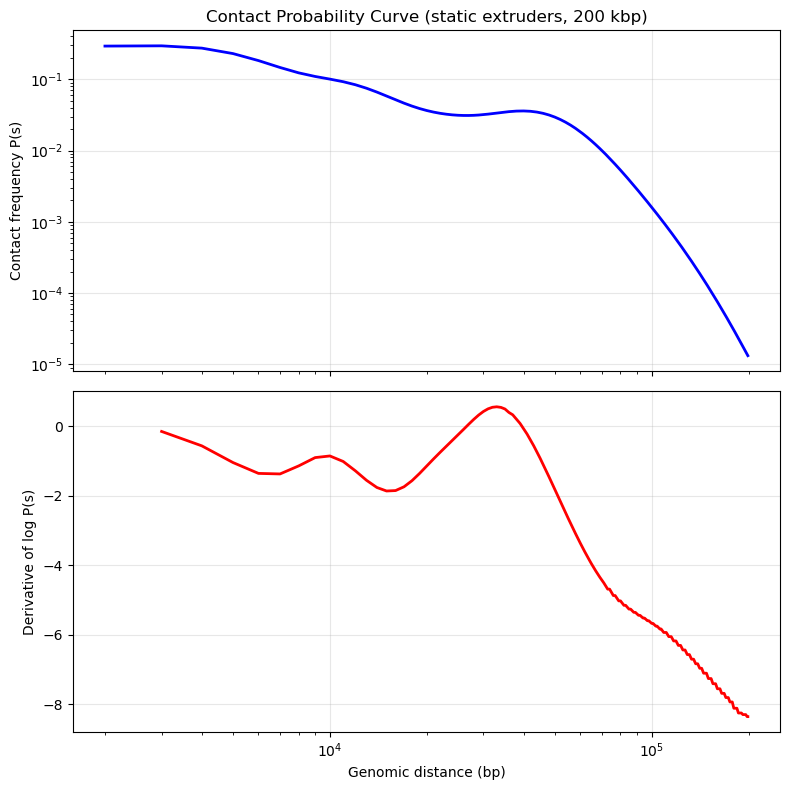

✓ P(s) curve plotted and saved!


In [22]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Top: P(s) curve
ax1.plot(cvd['s_bp'], cvd['balanced.avg.smoothed.agg'], color='blue', linewidth=2)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel('Contact frequency P(s)')
ax1.set_title(f'Contact Probability Curve ({simulation_type} extruders, 200 kbp)')
ax1.grid(True, alpha=0.3)

# Bottom: Derivative
ax2.plot(cvd['s_bp'], cvd['der'], color='red', linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('Genomic distance (bp)')
ax2.set_ylabel('Derivative of log P(s)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(path_to_cell + f'Ps_curve_{simulation_type}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ P(s) curve plotted and saved!")


### 5.7 Alternative: Run with DPD Potential

To use DPD potential instead of Step potential, make the following changes:

**1. Update imports in Cell 18:**
```python
from spatial_functions import (bondUpdater, lef_pos_calculator, make_start_conf, 
                                bond_calculator, orient_chain_along_z, dpd_repulsive)
```

**2. Change the nonbonded force function in Cell 29:**
```python
nonbonded_force_func=dpd_repulsive,  # DPD potential (from spatial_functions)
```

**3. Update the force name in milker.setup:**
```python
milker.setup(bondForce=a.force_dict['harmonic_bonds'],
             nonbondForce=a.force_dict["dpd_repulsive"],  # Changed
             blocks=restartSimulationEveryBlocks,
             except_bonds=except_bonds_from_updater)
```

**4. Adjust step_prob calculation in Cell 22 (remove factor of 6):**
```python
args_cond['step_prob'] = args_cond['velocity'] / (args_cond['n_steps'] * 33) * time_step_1d  # No × 6
```

**Note:** Both `polynomial_repulsive` and `dpd_repulsive` are now imported from `spatial_functions.py`, not from `polychrom.forces`.

The DPD potential provides smoother repulsion and can produce different contact probability curves. See the main article for detailed comparison between Step and DPD potentials.


## 6. Complete Workflow Summary

You have now completed the full workflow:

1. ✓ **1D Simulation**: Generated loop positions using ensemble_director
2. ✓ **3D Simulation**: Folded polymer in 3D using Polychrom with Step potential
3. ✓ **Contact Maps**: Created .mcool file from 3D conformations
4. ✓ **P(s) Analysis**: Calculated and visualized contact probability curves

## 7. Next Steps

For more advanced analysis:

1. **Compare with experimental data**:
   - Load experimental Hi-C data (.mcool files)
   - Compare P(s) curves using metrics (R², RMSE, MAE)
   - See `article_figures_visualization.ipynb` for examples

2. **Analyze loop statistics**:
   - Extract loop size distributions
   - Identify nested vs unnested loops
   - Compare different conditions (static vs dynamic, different lifetimes)

3. **Add Gaussian noise**:
   - Set `sigma_noise = 200` (nm) in Cell 32
   - Rerun contact map generation
   - Compare smoothed vs raw P(s) curves

4. **Scale up to production runs**:
   - Increase to 40 Mbp (as in main article)
   - Use multiple cells for better statistics
   - Try different extruder parameters (lifetime, velocity, force)

5. **Try DPD potential**:
   - Follow instructions in Section 5.7
   - Compare Step vs DPD potential results

For complete examples and figure generation, see:
- `article_figures_visualization.ipynb` - All figures from the article
- Main article: "Effects of Extruder Dynamics and Noise on Simulated Chromatin Contact Probability Curves"
